In [1]:
import numpy as np
import pandas as pd
import os
import h5py as h5
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class FileReader(object):
    def __init__(self, path, class_labels=['city','interurban','highway']):
        self.class_labels = class_labels
        self.path_to_filelist(path)
            
    def path_to_filelist(self, path):
        self.file_list = []
        if os.path.isfile(path=path):
            self.file_list.append(path)
        elif os.path.isdir(path):
            for fn in os.listdir(path):
                self.file_list.append(path + fn)
        
    
    def create_file_frame(self, filename, seed, vocab, approach='nengo', data=[], b_train=False):
        with h5.File(filename, 'r') as hf:
            pred_key='test_enhanced_pred'
            label_key = 'test_enhanced_label'
            if b_train:
                pred_key='train_pred'
                label_key='train_label'
                
            prediction_vecs = np.array(hf[pred_key])
            label = np.argmax(hf[label_key], axis=1)
            prediction = np.argmax(hf[pred_key], axis=1)
            l = np.min([len(label), len(prediction)])
            b_prediction = label[:l] == prediction[:l]
            confidence = prediction_vecs[prediction]
            
            for i in np.arange(l):
                
                dat_dict = dict(true_label=self.class_labels[label[i]], 
                            prediction_label=self.class_labels[prediction[i]], 
                            b_correct_prediction=b_prediction[i],
                            confidence=confidence[i][prediction[i]],
                            seed=seed,
                            vocab=vocab,
                            approach=approach)

                data.append(dat_dict)

        return pd.DataFrame(data), data
    
    def create_plot_frame_from_file_frame(self, file_frame):
        data = []
        for app in np.unique(file_frame['approach']):
            for vocab in np.unique(file_frame.query('approach == "%s"'%app)['vocab']):
                for seed in np.unique(file_frame.query('approach == "%s" and vocab == "%s"'%(app, vocab))['seed']):
                    df = file_frame.query('approach == "%s" and vocab == "%s" and seed == %i'%(app, vocab, seed))
                    dat_dict = dict(
                        approach=app,
                        vocab=vocab,
                        seed=seed,
                        percentage=100*np.sum(df['b_correct_prediction'])/len(df['b_correct_prediction']),
                        label='total'
                        )
                    data.append(dat_dict)
                    
                    for label in self.class_labels:
                        dat_dict = dict(
                            approach=app,
                            vocab=vocab,
                            seed=seed,
                            percentage=100*np.sum(df.query('true_label=="%s"'%label)['b_correct_prediction'])/len(df.query('true_label=="%s"'%label)['b_correct_prediction']),
                            label=label
                        )
                        data.append(dat_dict)
                        
        return pd.DataFrame(data)
                    

In [3]:
fr = FileReader(path='/media/flo/LACIE_HD1/data/Baseline/')

In [4]:
data = []
for i, fn in enumerate(fr.file_list):
    df, data = fr.create_file_frame(fn, seed=i, vocab='random', approach='nengo improved', data=data, b_train=False)

In [5]:
fr.path_to_filelist(path='/media/flo/LACIE_HD1/data/TS_TP_sem_manual/')
for i, fn in enumerate(fr.file_list):
    df, data = fr.create_file_frame(fn, seed=i, vocab='semantic manual', approach='nengo improved', data=data, b_train=False)

In [6]:
fr = FileReader(path='/media/flo/LACIE_HD1/data/TS_TP_visual/')
for i, fn in enumerate(fr.file_list):
    df, data = fr.create_file_frame(fn, seed=i, vocab='visual', approach='nengo improved', data=data, b_train=False)

In [7]:
fr = FileReader(path='/media/flo/LACIE_HD1/data/TS_TP_vis_sem/')
for i, fn in enumerate(fr.file_list):
    df, data = fr.create_file_frame(fn, seed=i, vocab='visual semantic', approach='nengo improved', data=data, b_train=False)

In [8]:
plot_df = fr.create_plot_frame_from_file_frame(file_frame=df)

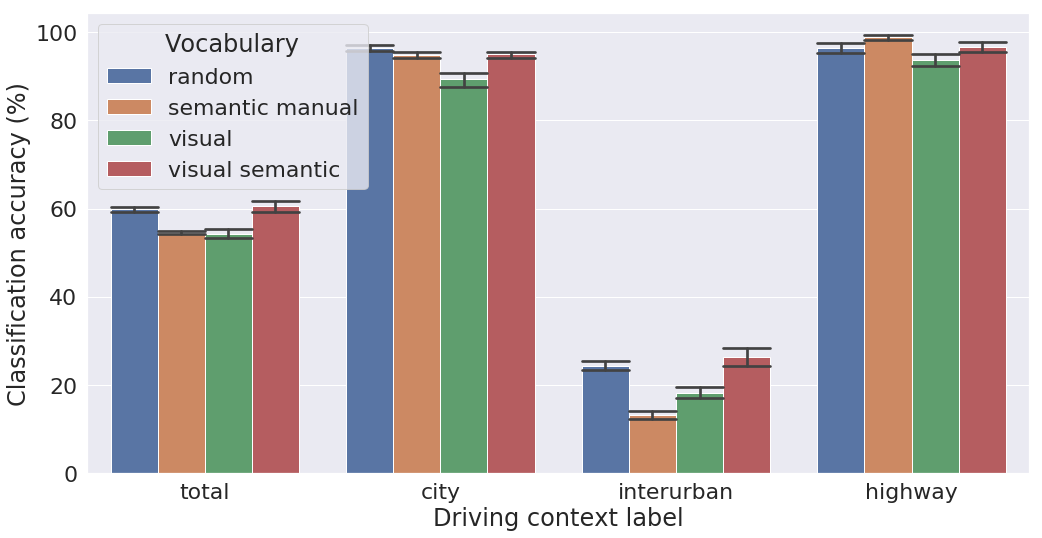

In [9]:
sns.set_style("darkgrid")
sns.set(font_scale=2)
fig = plt.figure(figsize=(15,8))
ax = sns.barplot(x='label', y='percentage', hue='vocab', data=plot_df, capsize=0.2)
# ax.set_title('distances to closest vehicle')
# ax2[1].set_title('distances to ego-vehicle')
ax.set_xlabel('Driving context label')
ax.set_ylabel('Classification accuracy (%)')
ax.legend(title='Vocabulary', frameon=True, loc='upper left')
# ax.set_ylim([20,100])
plt.tight_layout()
plt.savefig('/home/flo/git/diss/thesis/imgs/context_class_vocabularies_tp_and_ts.eps', dpi=1200)
plt.show()